In [3]:
import torch
import torch.nn as nn
import pandas as pd 

from matplotlib import pyplot as plt 
import matplotlib


In [4]:

df = pd.read_csv('particle_data.csv')
df

,mass2,p,pT,rapidity,t,v_tof,pid
0,1.206447,8.217851,0.637015,2.675371,25.658752,29.712942,0.0
1,1.159665,7.748465,1.175239,2.330483,26.537636,29.695267,0.0
2,0.861685,6.905441,0.579728,2.530320,25.656970,29.711910,0.0
3,0.912960,3.572433,0.493861,1.919919,27.418829,28.955194,0.0
4,0.855859,3.760208,0.348766,2.029716,26.879280,29.098831,0.0
...,...,...,...,...,...,...,...
1817896,0.246887,2.584729,0.140964,2.317712,26.839771,29.443060,1.0
1817897,0.961281,4.424352,0.344987,2.190138,27.128212,29.262716,0.0
1817898,0.035658,1.131818,0.340875,1.796098,26.262580,29.552643,2.0
1817899,0.860461,2.839349,0.728590,1.574306,26.653654,28.473682,0.0


In [5]:


def train_test_split(df:pd.DataFrame ):
    crosspoint = len(df)*3//4
    return df[:crosspoint], df[crosspoint:]
df_train, df_test = train_test_split(df)

X_train = df_train 
Y_train = df_train["pid"]
X_train = X_train.drop(columns="pid")

X_test = df_test 
Y_test = df_test["pid"]
X_test = X_test.drop(columns="pid")

X_test

,mass2,p,pT,rapidity,t,v_tof
1363425,0.180881,2.372725,0.454459,1.957612,25.819763,29.496902
1363426,0.012839,0.782998,0.228159,1.753384,27.800797,29.647102
1363427,0.011845,0.940181,0.271188,1.803022,25.498678,29.767570
1363428,0.903536,2.197572,0.629638,1.380773,27.939068,27.363283
1363429,-0.053686,3.453497,0.566588,2.464815,25.582424,30.048048
...,...,...,...,...,...,...
1817896,0.246887,2.584729,0.140964,2.317712,26.839771,29.443060
1817897,0.961281,4.424352,0.344987,2.190138,27.128212,29.262716
1817898,0.035658,1.131818,0.340875,1.796098,26.262580,29.552643
1817899,0.860461,2.839349,0.728590,1.574306,26.653654,28.473682


In [6]:

 
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(6, 16)
        self.act = nn.ReLU()
        self.output = nn.Linear(16, 3)
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    
model = Multiclass()

import torch.optim as optim
 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
model.load_state_dict(torch.load('particleclassifier.torch'))
model.eval()

Multiclass(
  (hidden): Linear(in_features=6, out_features=16, bias=True)
  (act): ReLU()
  (output): Linear(in_features=16, out_features=3, bias=True)
)

In [9]:
torch.save(model.state_dict(), 'particleclassifier.torch')

In [10]:

X = torch.tensor(X_test.values, dtype=torch.float32)
y_pred = model(X)
y_pred = y_pred.detach().numpy()


In [11]:

y_pred.transpose()[0]

array([ -8.812234, -23.753206, -23.269278, ..., -21.713184,  11.949246,
       -26.376621], dtype=float32)

In [12]:
X_test['pid'] = Y_test
X_test['pid_pred0'], X_test['pid_pred1'], X_test['pid_pred2'] = y_pred.transpose() 

<Axes: >

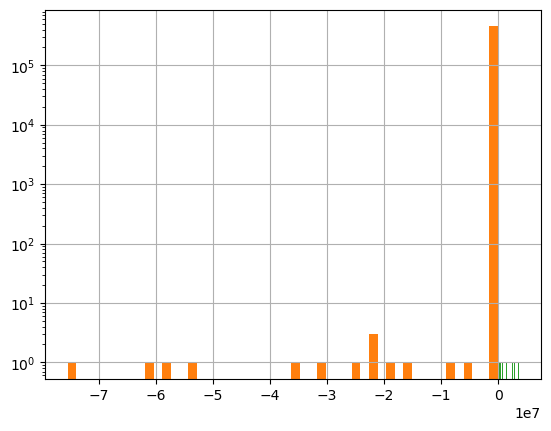

In [13]:
X_test['pid_pred0'].hist(bins=50,log=True)
X_test['pid_pred1'].hist(bins=50, log=True)
X_test['pid_pred2'].hist(bins=50,log=True)

226581
226929
226577
352


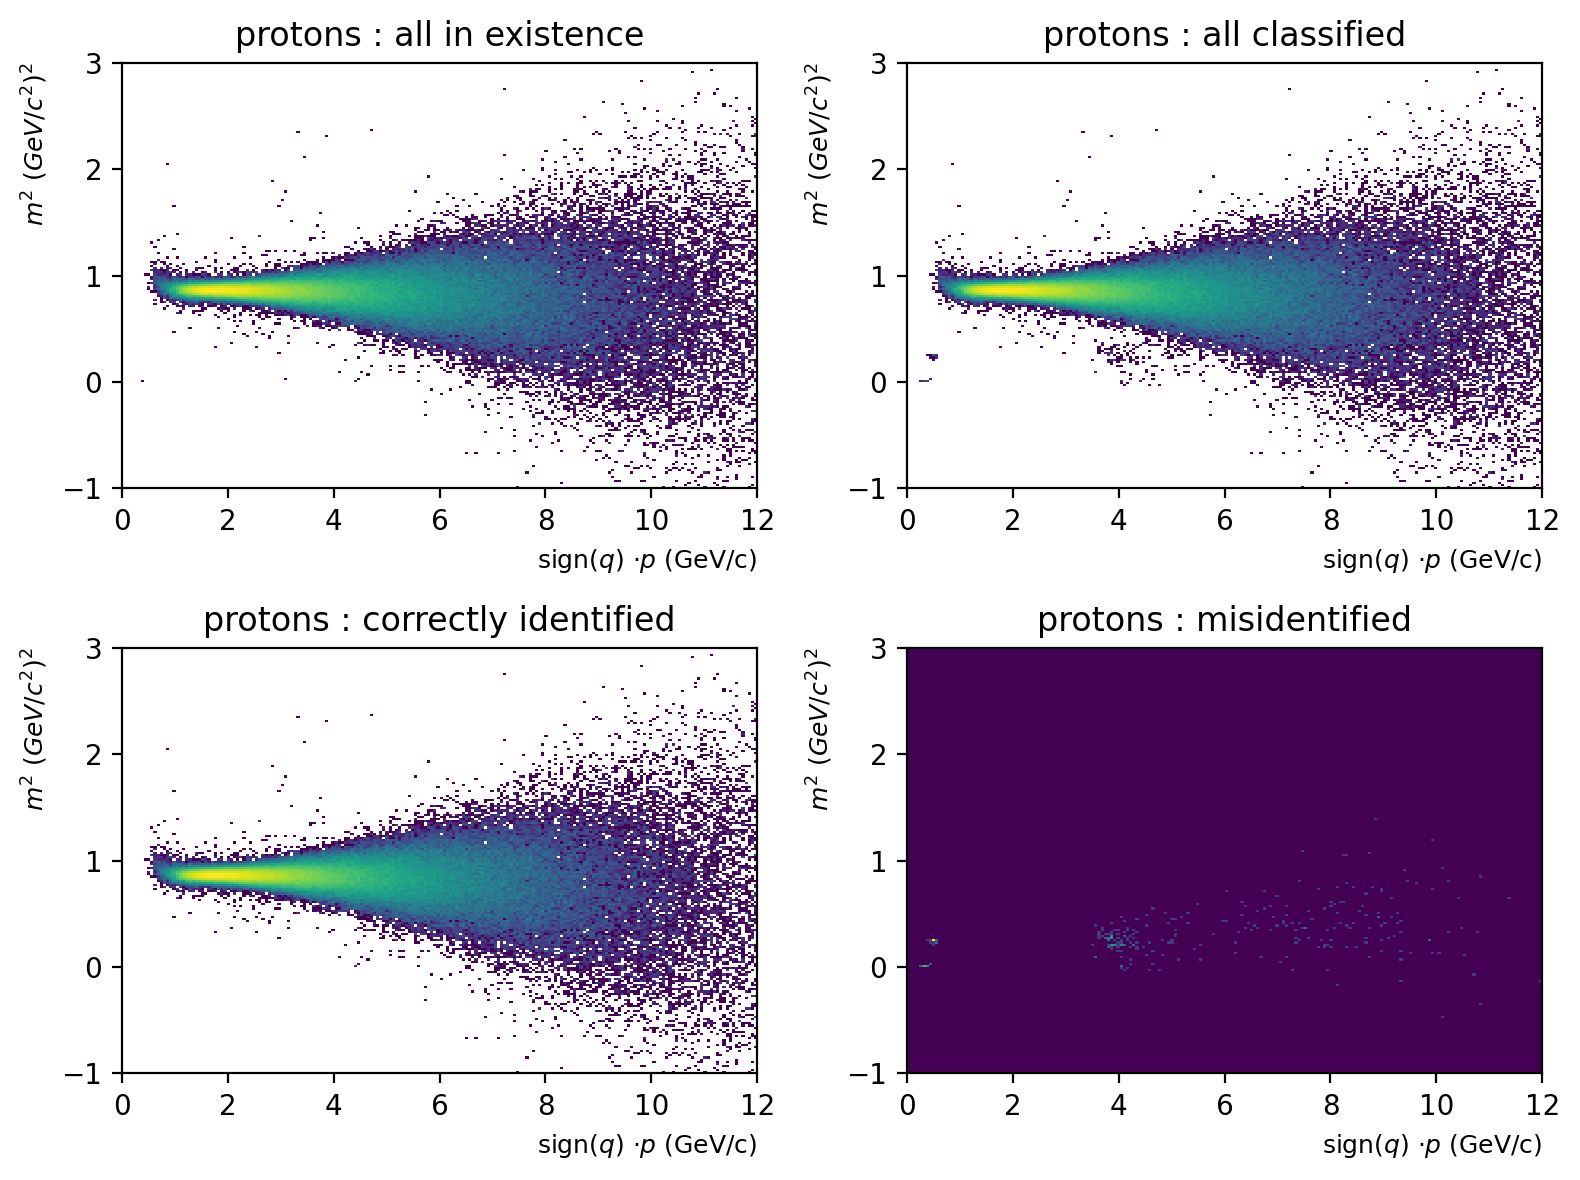

19208
19203
18881
322


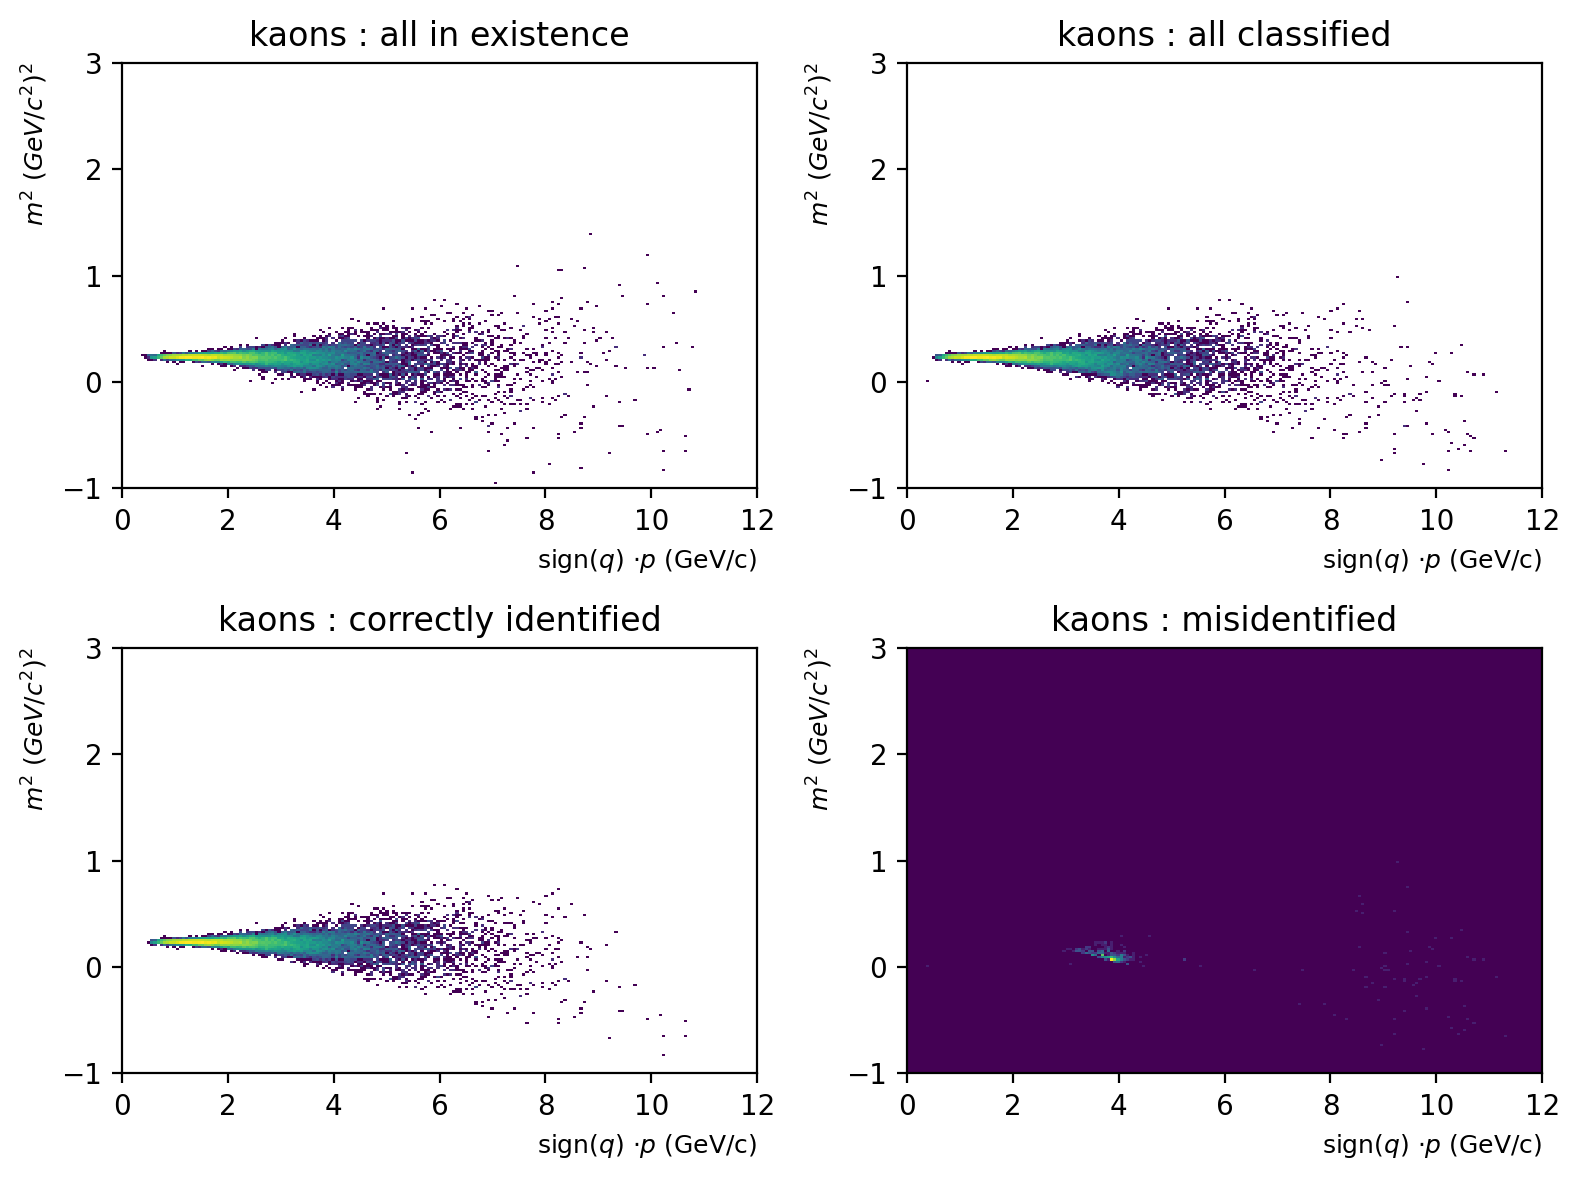

208687
208344
208255
89


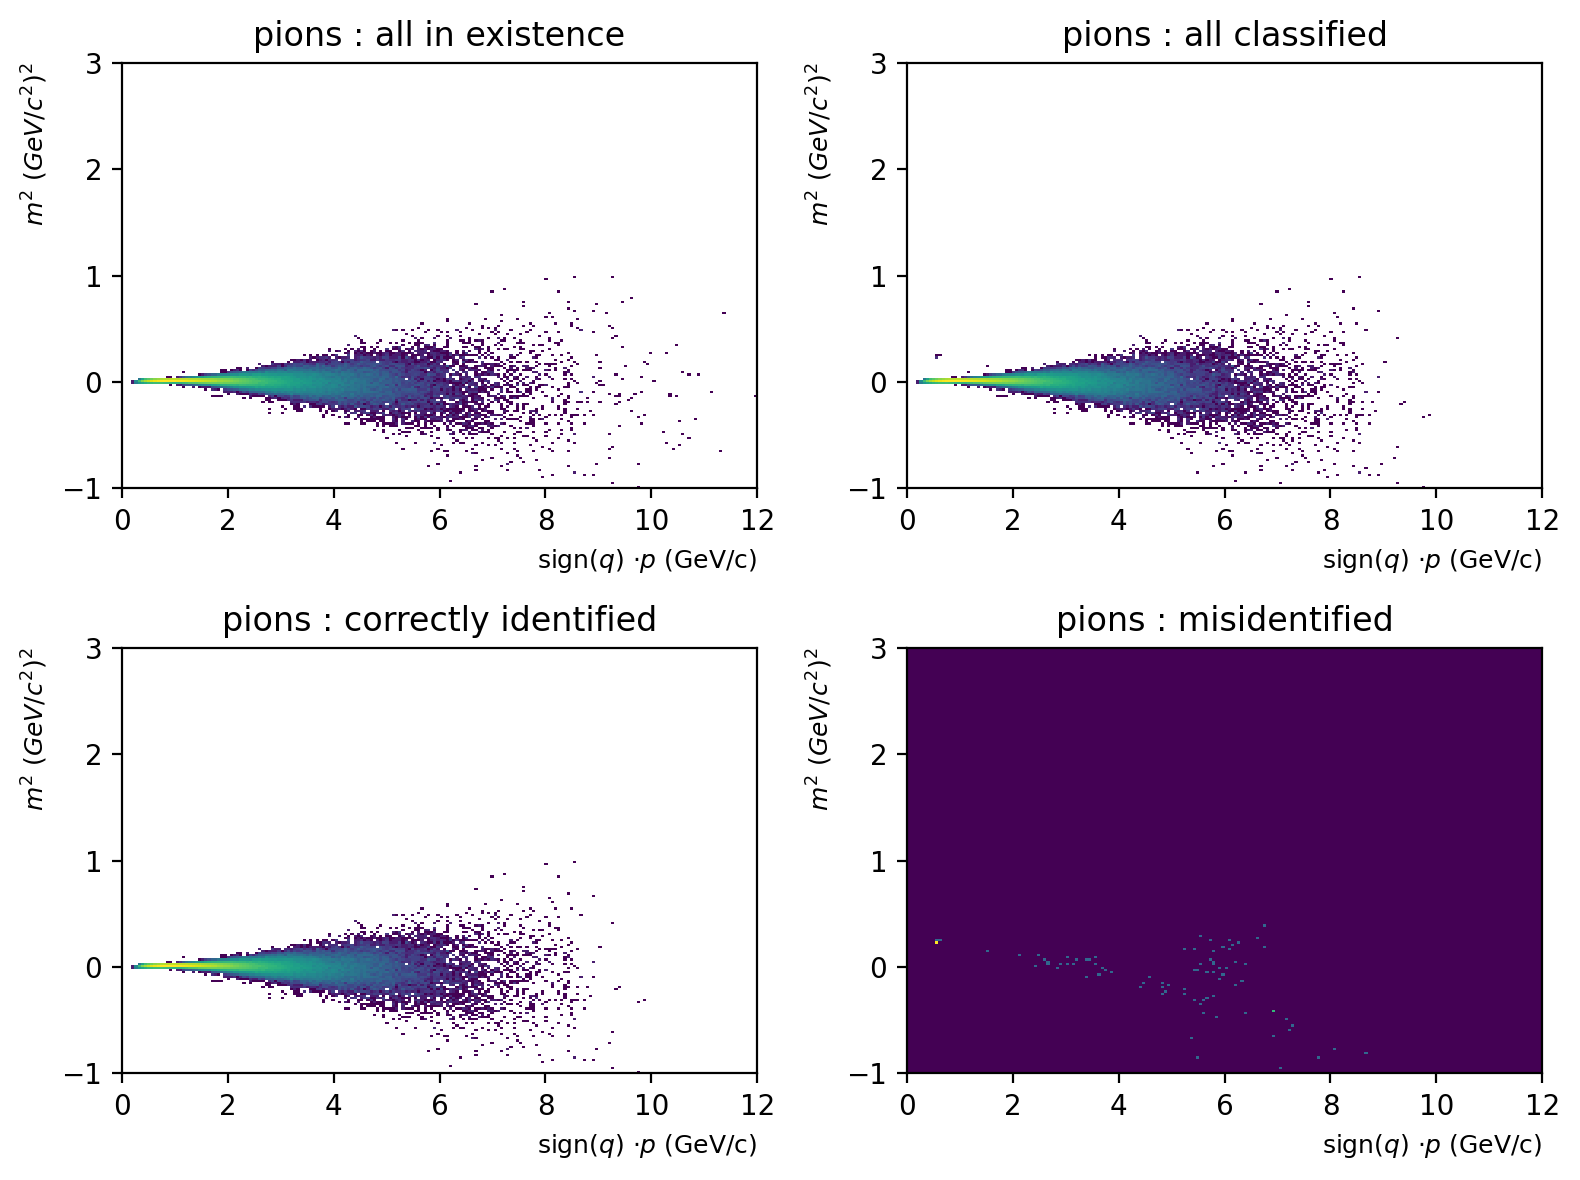

In [14]:

from matplotlib import pyplot as plt
import matplotlib



def selection(df, key):
    return df.loc[(df[key] >= df['pid_pred0']) & (df[key] >= df['pid_pred1']) & (df[key] >= df['pid_pred2']) ] #and df[key]/(df['pid_pred0'] + df['pid_pred1'] + df['pid_pred2']) > minpurity

def draw_tof_plot(df : pd.DataFrame, pid:int, particle_name ):
    key = f'pid_pred{pid}'

    fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=200)
    
    all_protons = df.loc[df['pid'] == pid]
    print(len(all_protons))
    ax[0,0].hist2d(all_protons['p'], all_protons['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])
    
    all_identified = selection(df, key)
    print(len(all_identified))
    ax[0,1].hist2d(all_identified['p'], all_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])

    well_identified=all_identified.loc[df['pid'] == pid]
    print(len(well_identified))
    ax[1,0].hist2d(well_identified['p'], well_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])

    misidentified=all_identified.loc[df['pid'] != pid]
    print(len(misidentified))
    ax[1,1].hist2d(misidentified['p'], misidentified['mass2'], bins=200, range=[(0,12), (-1,3)])

    x_axis_name = r"sign($q$) $\cdot p$ (GeV/c)"
    y_axis_name = r"$m^2$ $(GeV/c^2)^2$"





    ax[0,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[0,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   

    ax[0,0].set_title(f'{particle_name} : all in existence')
    ax[0,1].set_title(f'{particle_name} : all classified')
    ax[1,0].set_title(f'{particle_name} : correctly identified')
    ax[1,1].set_title(f'{particle_name} : misidentified')
    fig.tight_layout()
    plt.show()

draw_tof_plot(X_test, 0,'protons')
draw_tof_plot(X_test, 1,'kaons')
draw_tof_plot(X_test, 2,'pions')

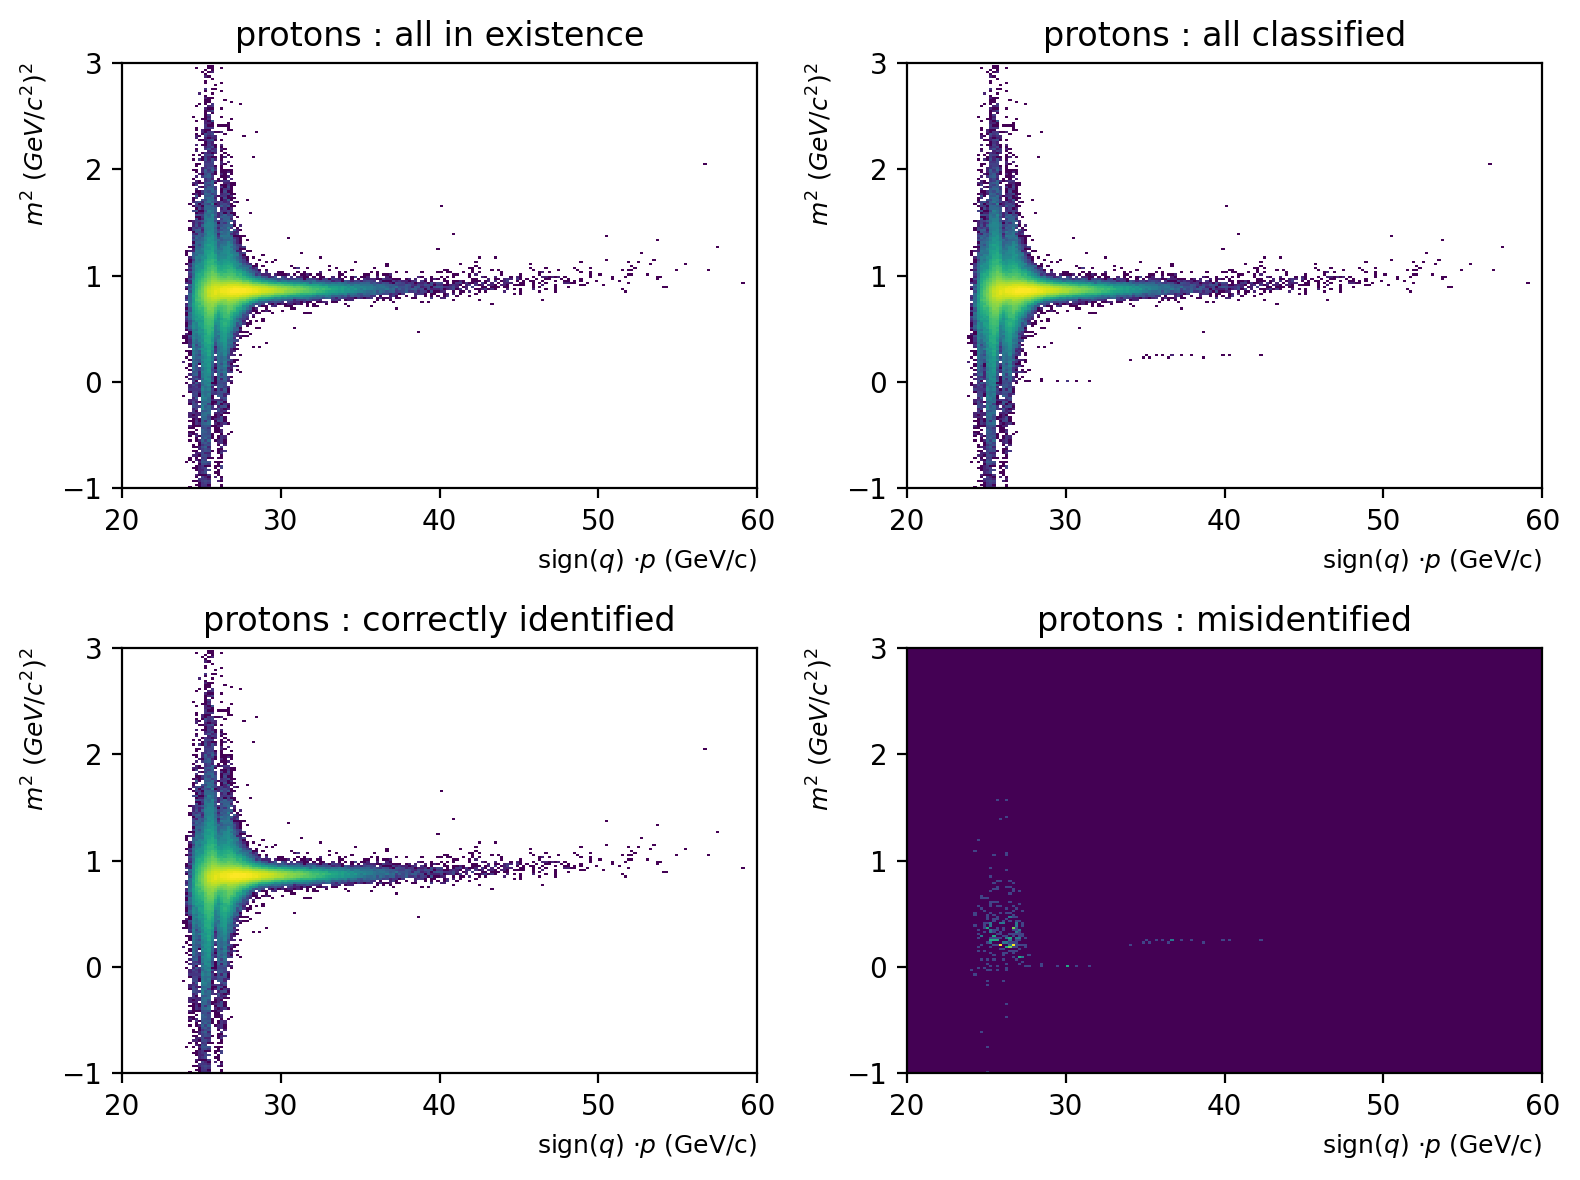

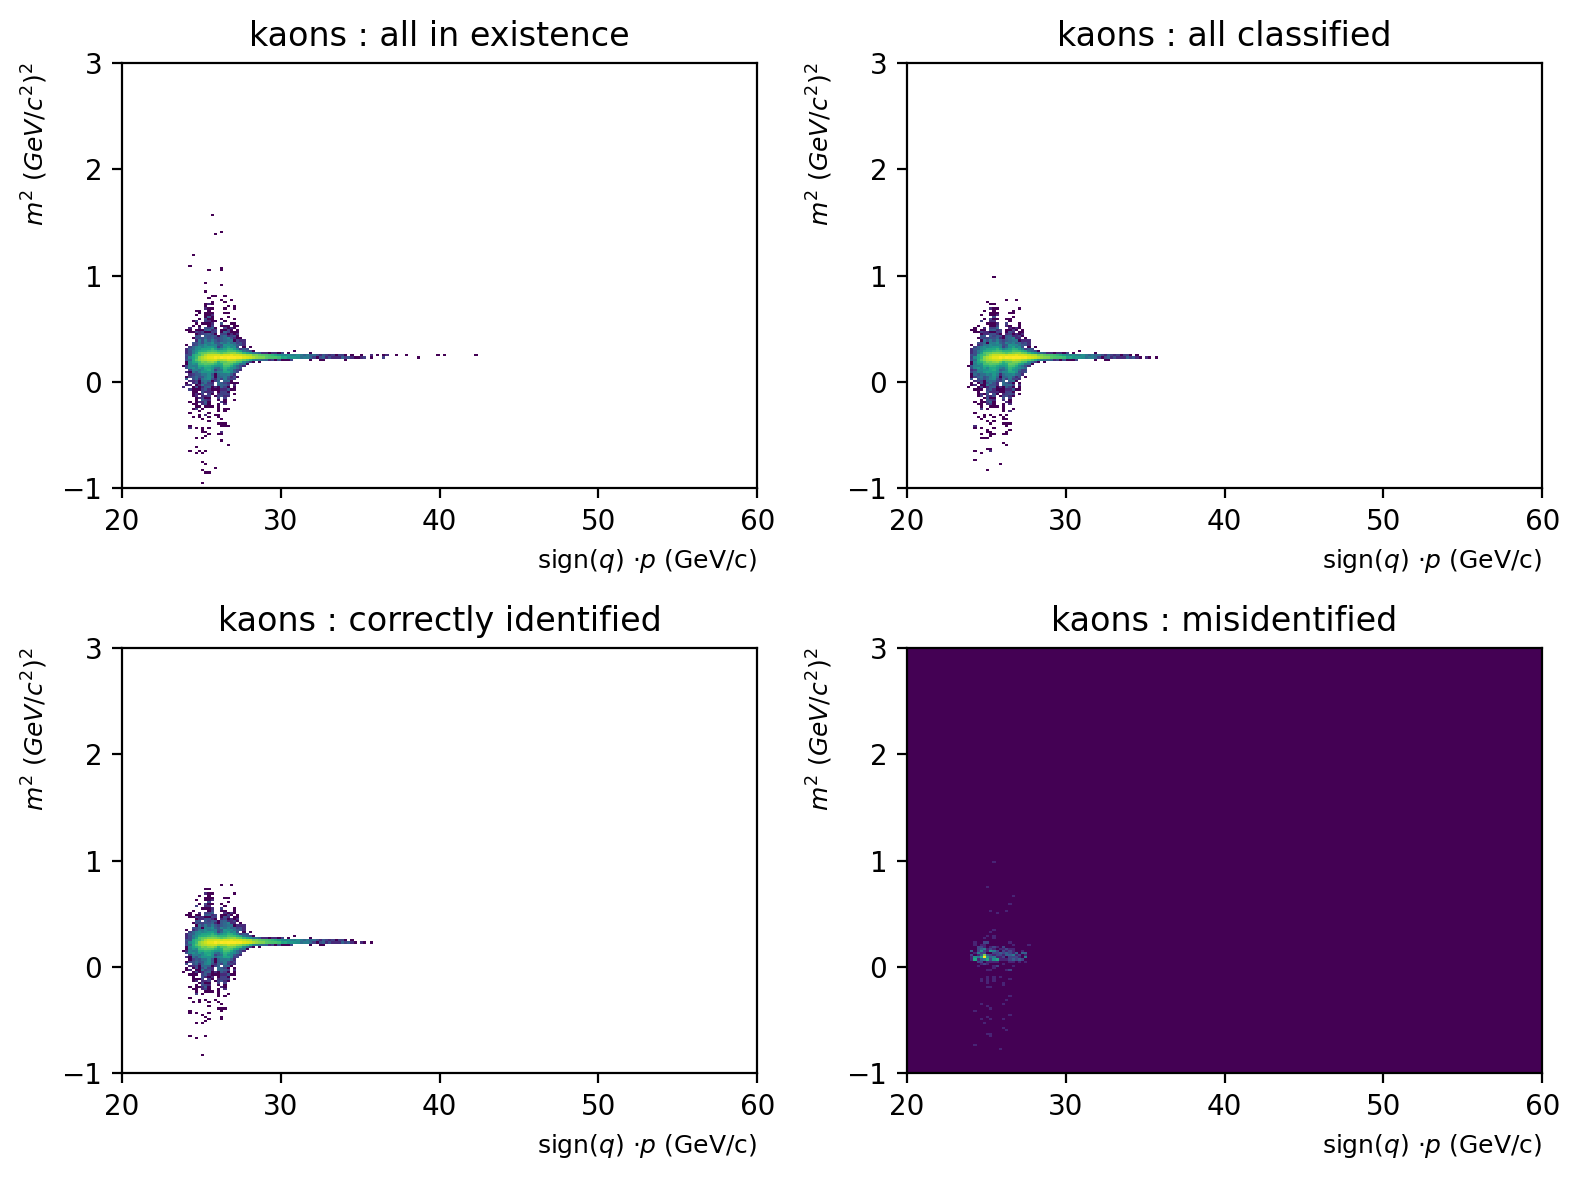

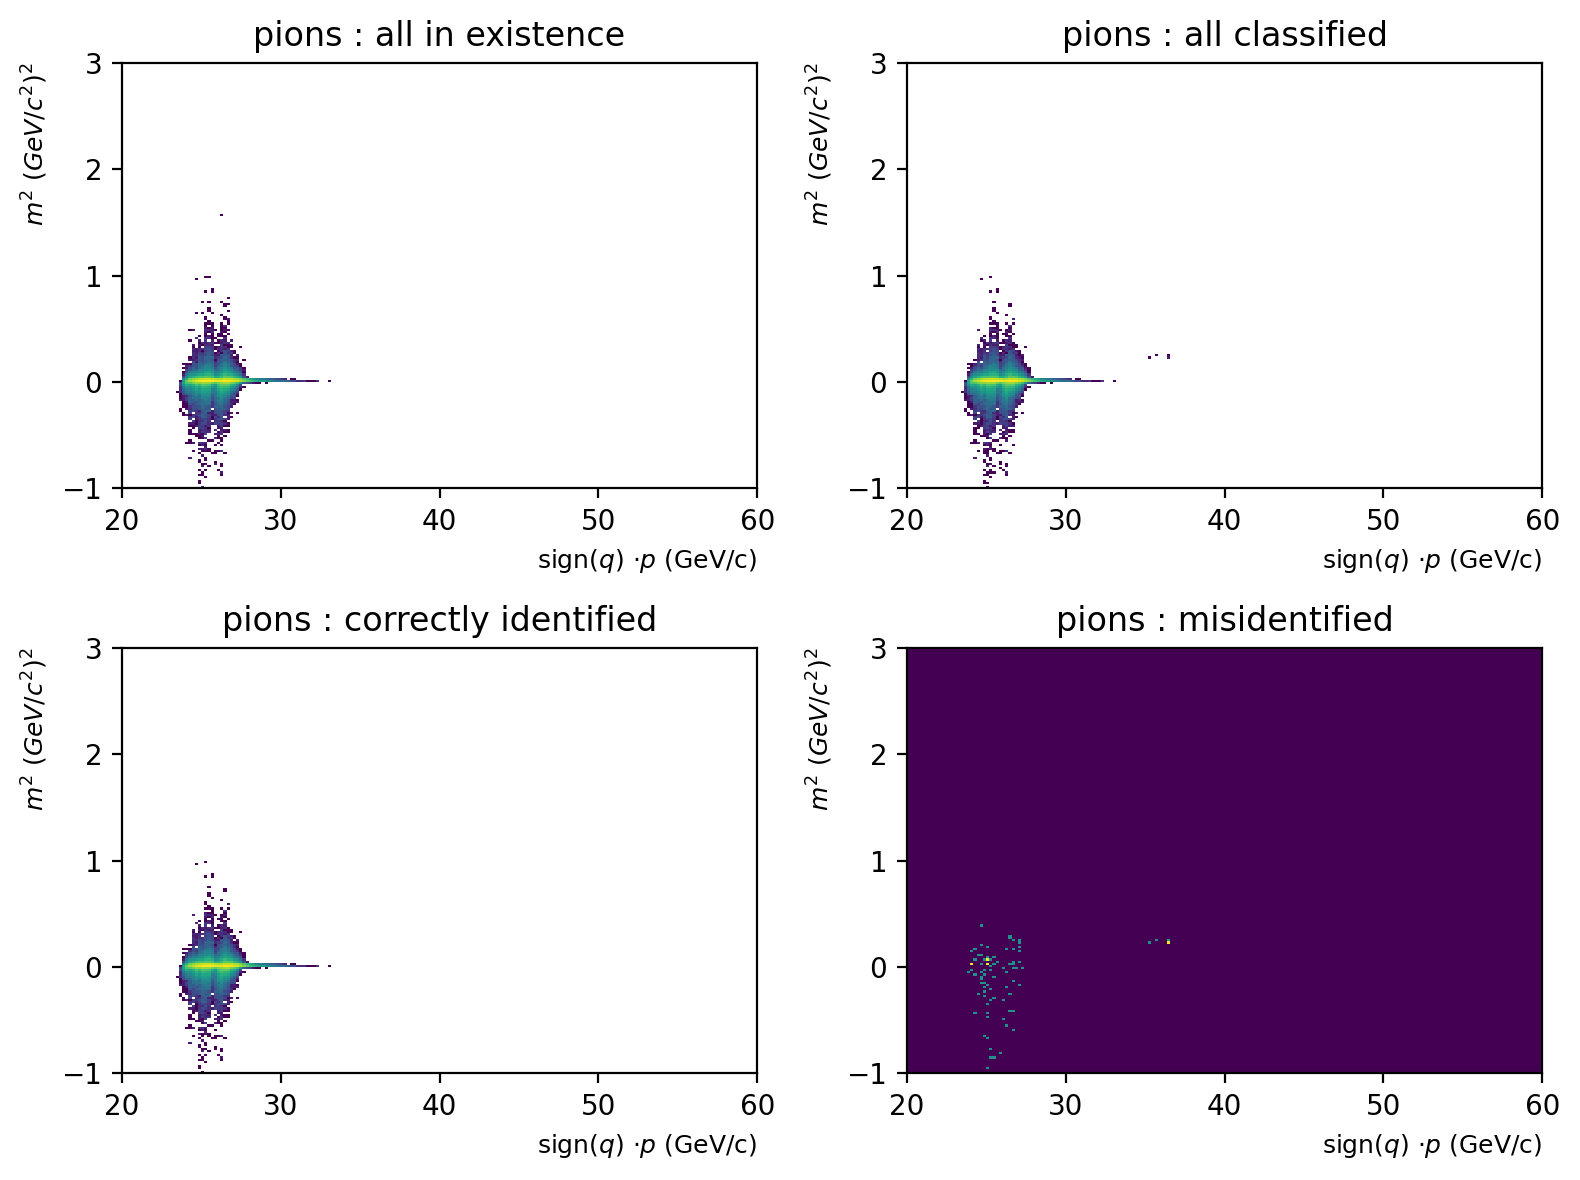

In [17]:

def draw_t_m2_plot(df : pd.DataFrame, pid:int, particle_name ):
    key = f'pid_pred{pid}'

    fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=200)
    ranges = [(20,60), (-1,3)]
    
    all_protons = df.loc[df['pid'] == pid]
    ax[0,0].hist2d(all_protons['t'], all_protons['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)
    
    all_identified = selection(df, key)
    ax[0,1].hist2d(all_identified['t'], all_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)

    well_identified=all_identified.loc[df['pid'] == pid]
    ax[1,0].hist2d(well_identified['t'], well_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)

    misidentified=all_identified.loc[df['pid'] != pid]
    ax[1,1].hist2d(misidentified['t'], misidentified['mass2'], bins=200, range=ranges)

    x_axis_name = r"t"
    y_axis_name = r"$m^2$ $(GeV/c^2)^2$"

    ax[0,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[0,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   

    ax[0,0].set_title(f'{particle_name} : all in existence')
    ax[0,1].set_title(f'{particle_name} : all classified')
    ax[1,0].set_title(f'{particle_name} : correctly identified')
    ax[1,1].set_title(f'{particle_name} : misidentified')
    fig.tight_layout()
    plt.show()

draw_t_m2_plot(X_test, 0,'protons')
draw_t_m2_plot(X_test, 1,'kaons')
draw_t_m2_plot(X_test, 2,'pions')

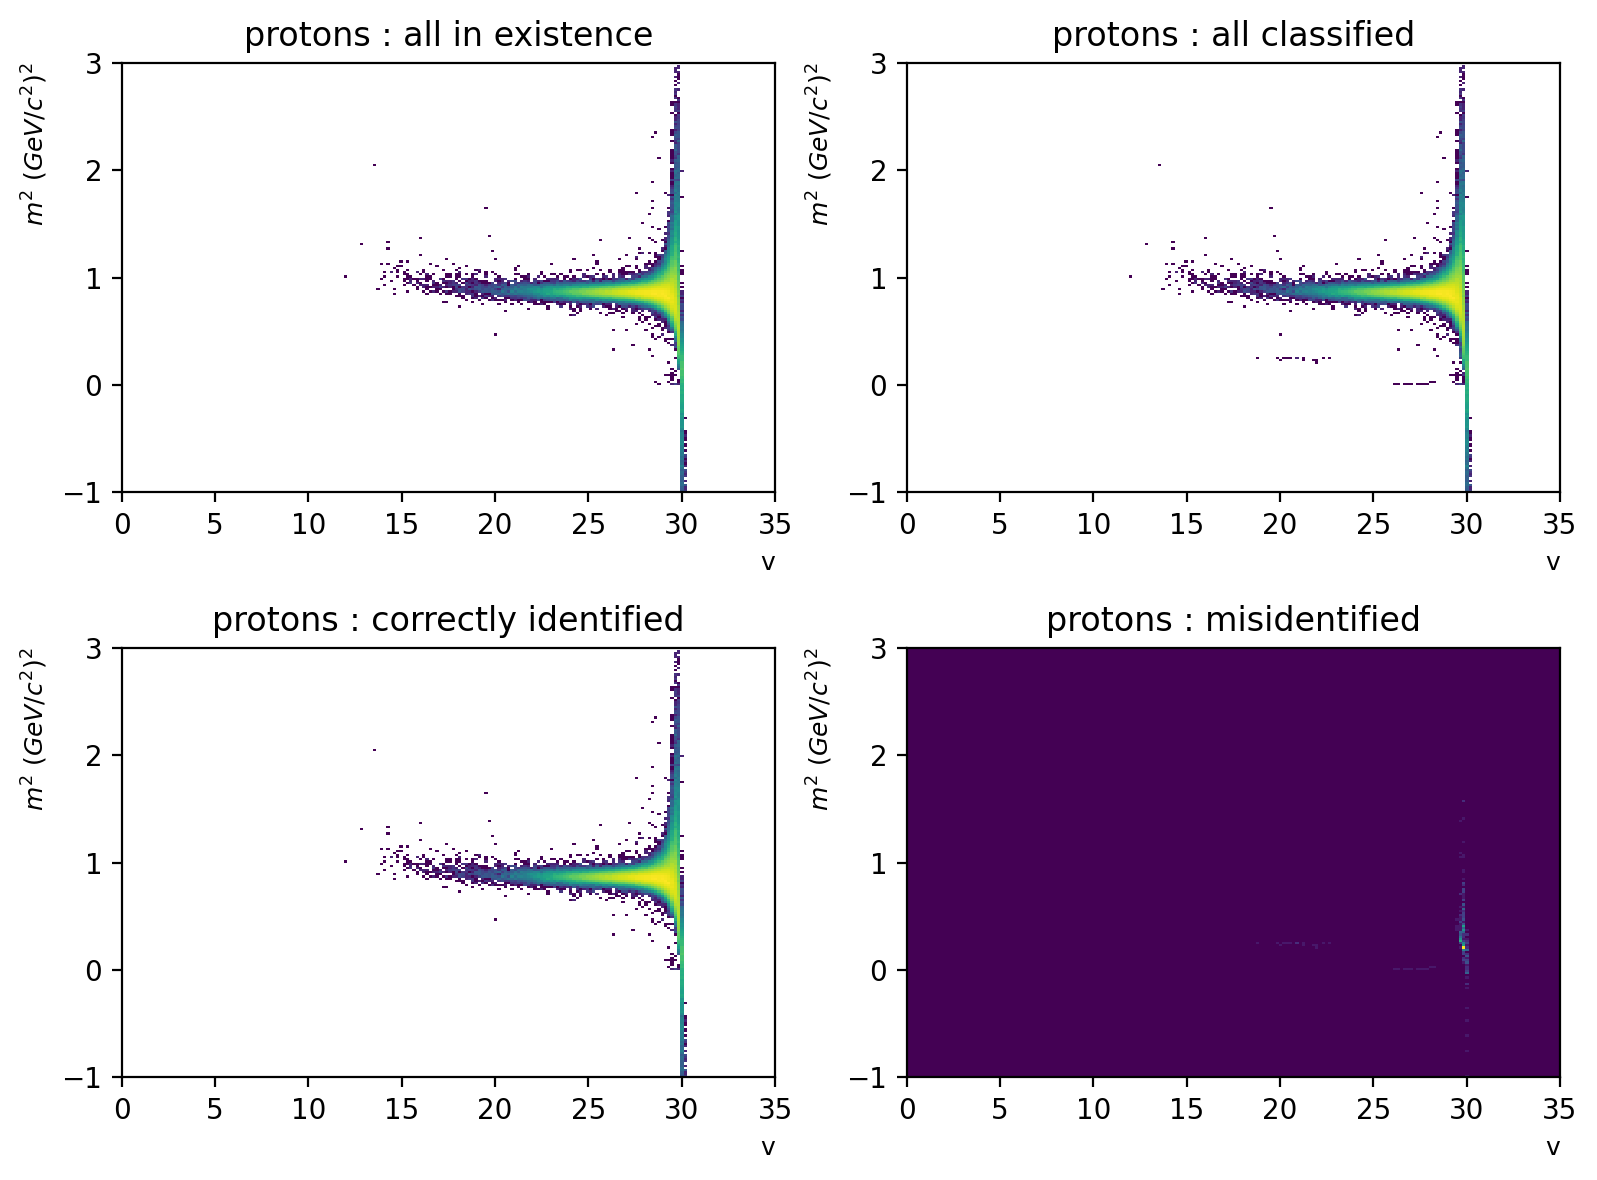

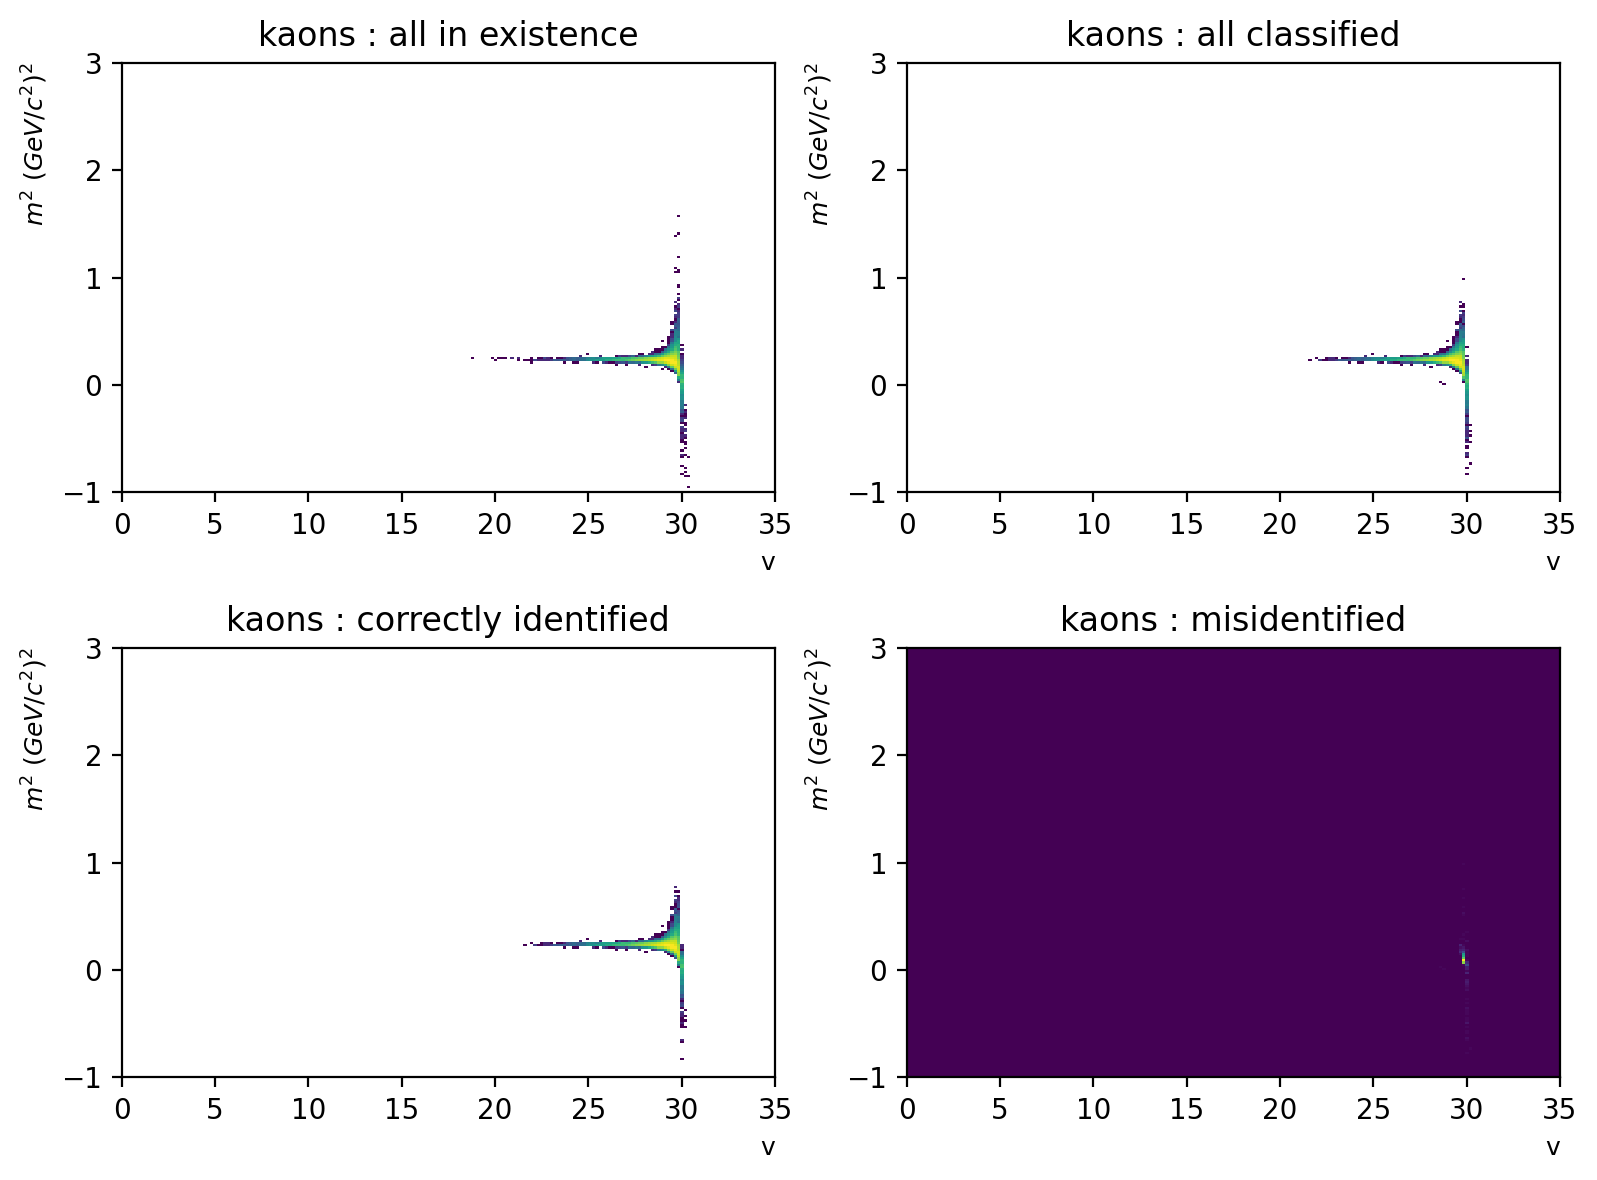

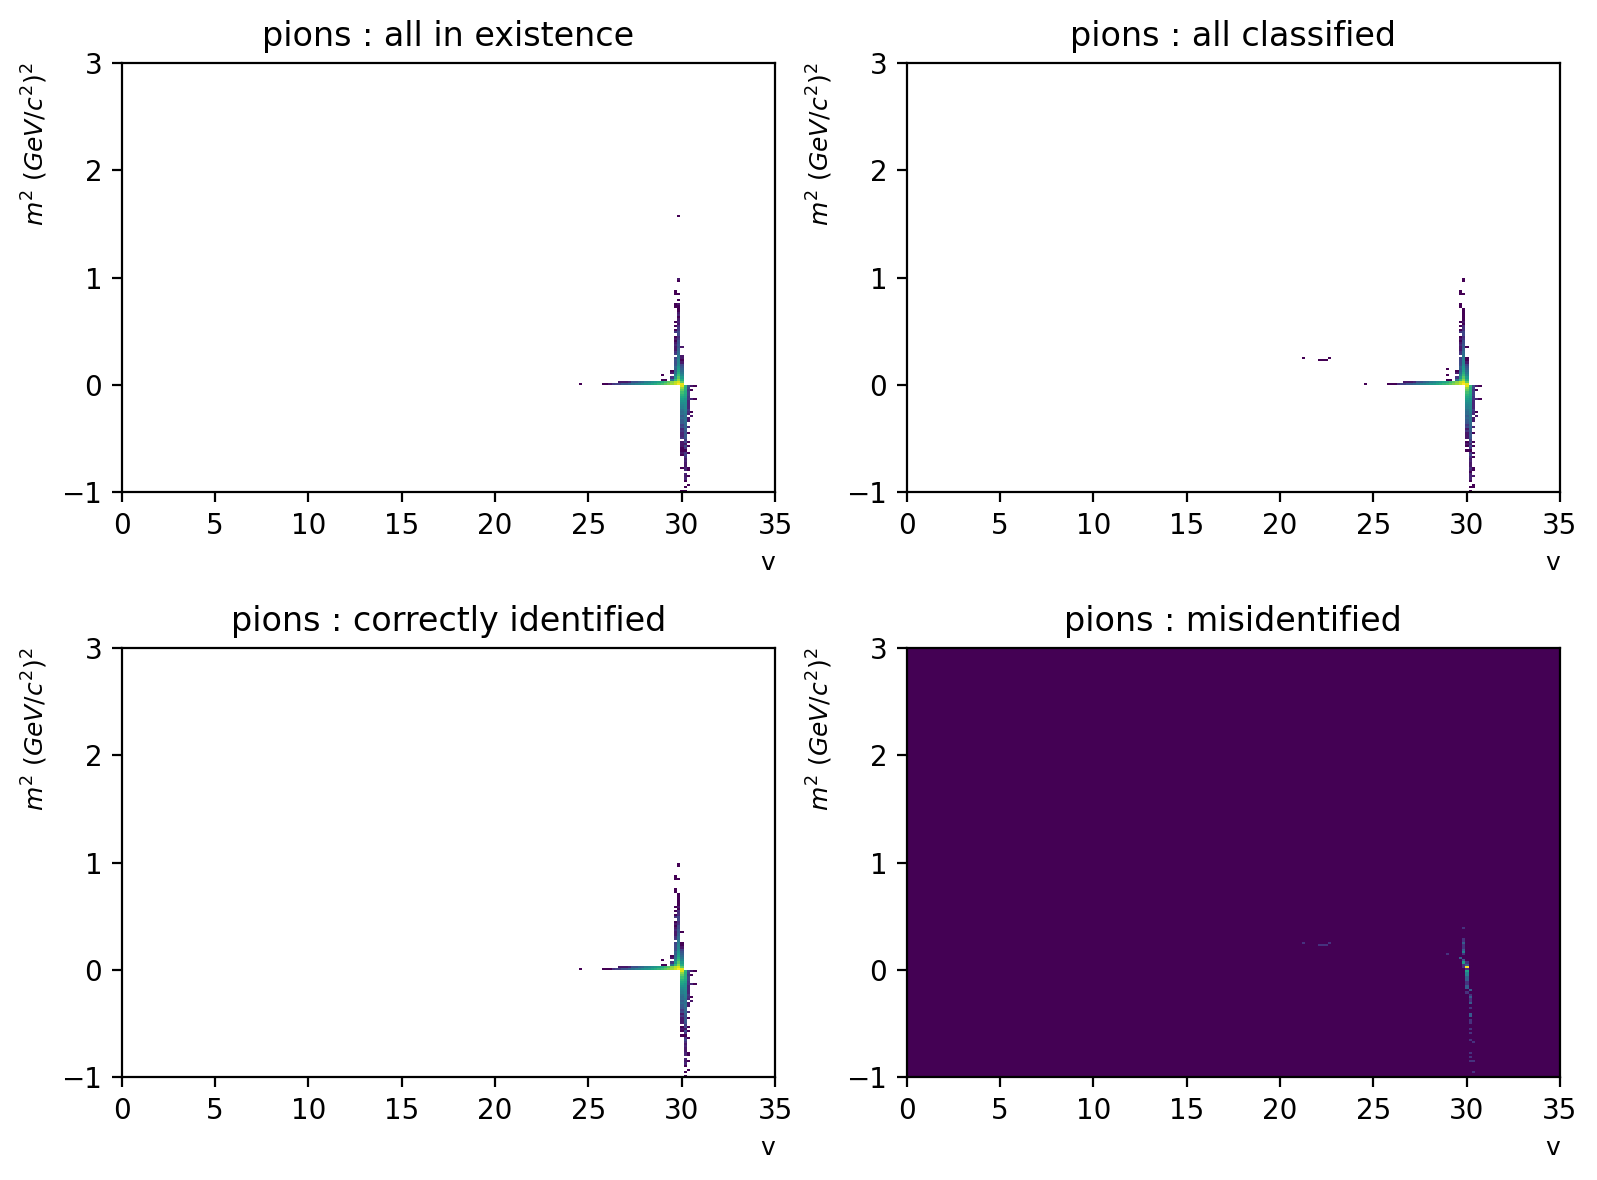

In [24]:
def draw_v_m2_plot(df : pd.DataFrame, pid:int, particle_name ):
    key = f'pid_pred{pid}'

    fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=200)
    ranges = [(0,35), (-1,3)]
    
    all_protons = df.loc[df['pid'] == pid]
    ax[0,0].hist2d(all_protons['v_tof'], all_protons['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)
    
    all_identified = selection(df, key)
    ax[0,1].hist2d(all_identified['v_tof'], all_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)

    well_identified=all_identified.loc[df['pid'] == pid]
    ax[1,0].hist2d(well_identified['v_tof'], well_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)

    misidentified=all_identified.loc[df['pid'] != pid]
    ax[1,1].hist2d(misidentified['v_tof'], misidentified['mass2'], bins=200, range=ranges)

    x_axis_name = r"v"
    y_axis_name = r"$m^2$ $(GeV/c^2)^2$"

    ax[0,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[0,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   

    ax[0,0].set_title(f'{particle_name} : all in existence')
    ax[0,1].set_title(f'{particle_name} : all classified')
    ax[1,0].set_title(f'{particle_name} : correctly identified')
    ax[1,1].set_title(f'{particle_name} : misidentified')
    fig.tight_layout()
    plt.show()

draw_v_m2_plot(X_test, 0,'protons')
draw_v_m2_plot(X_test, 1,'kaons')
draw_v_m2_plot(X_test, 2,'pions')

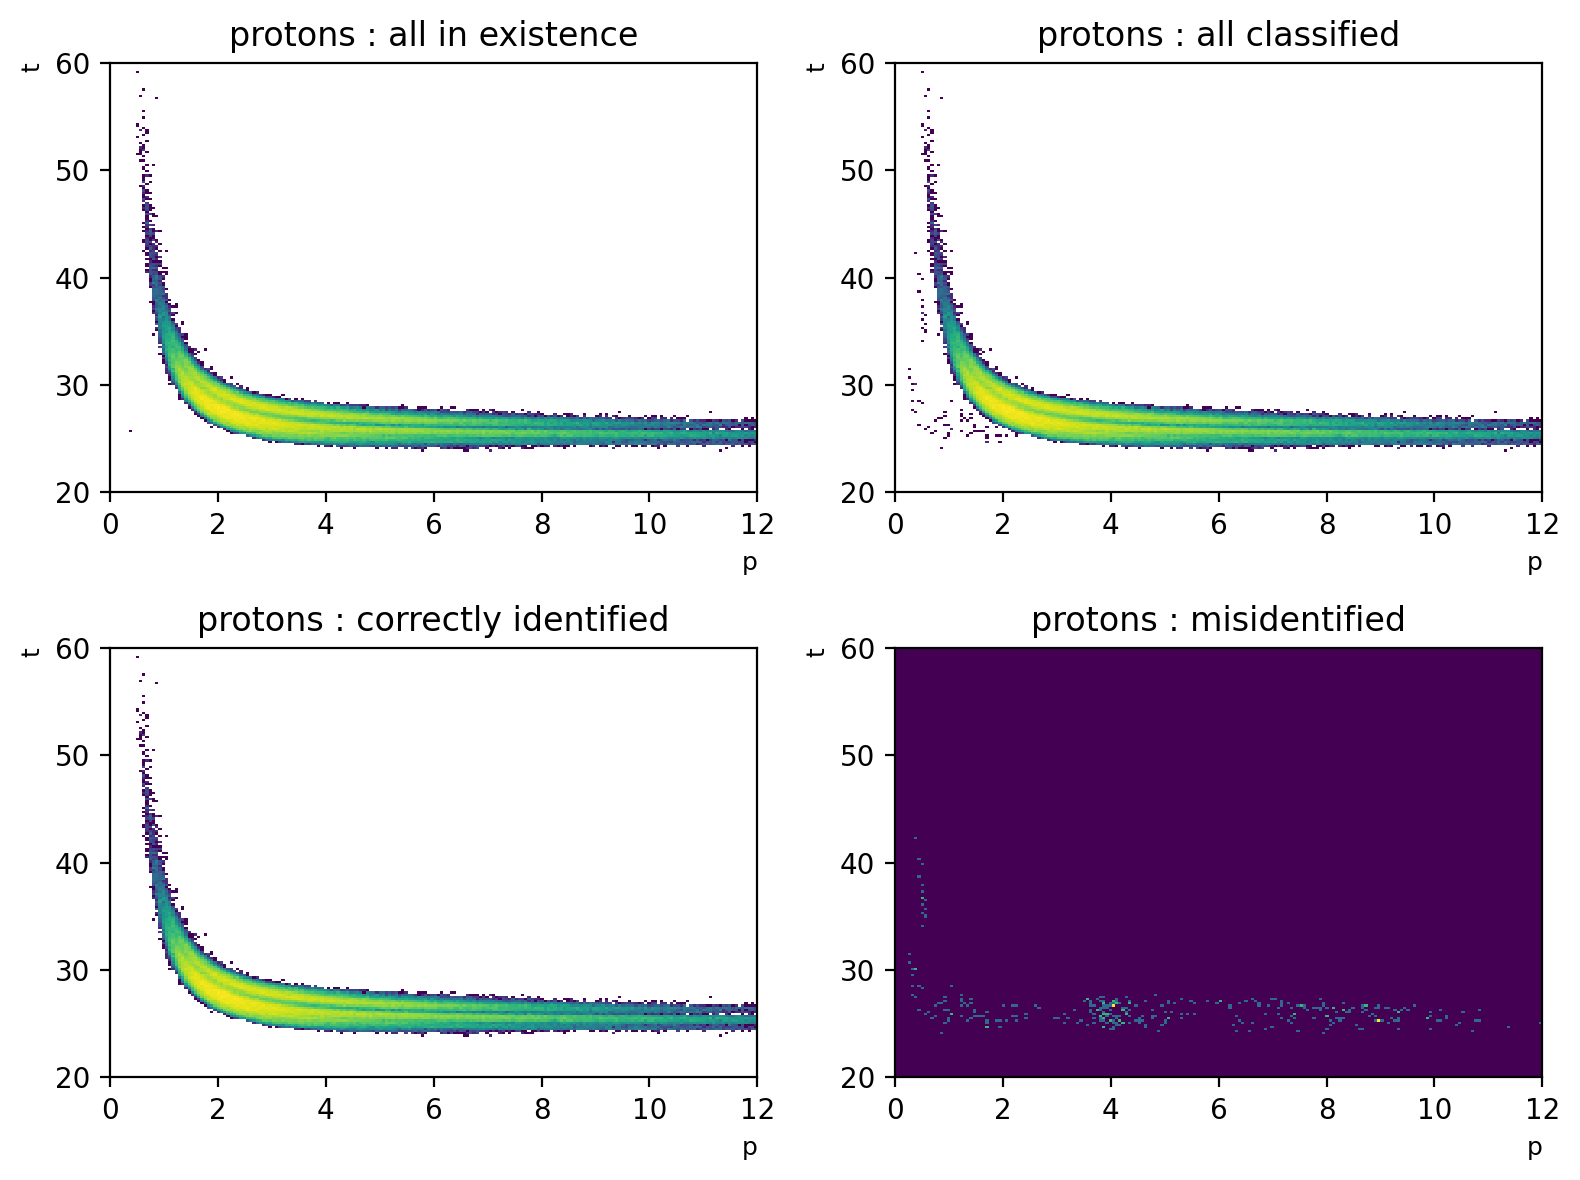

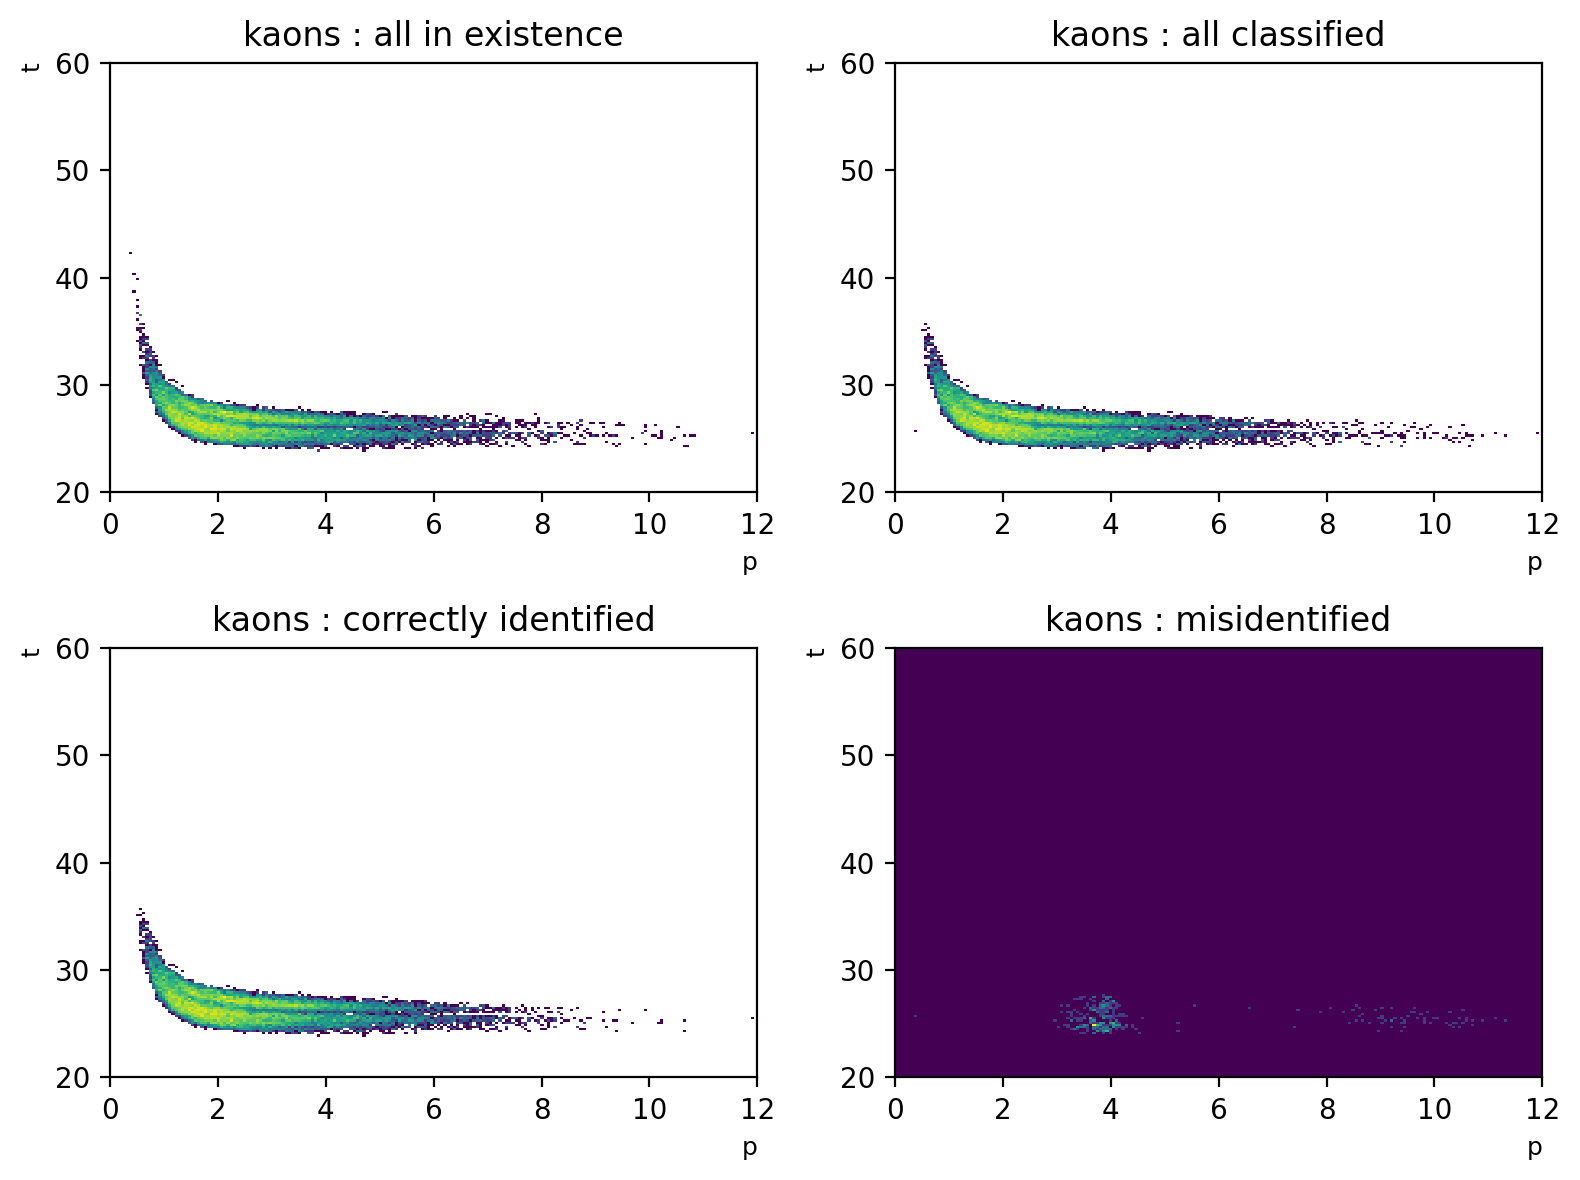

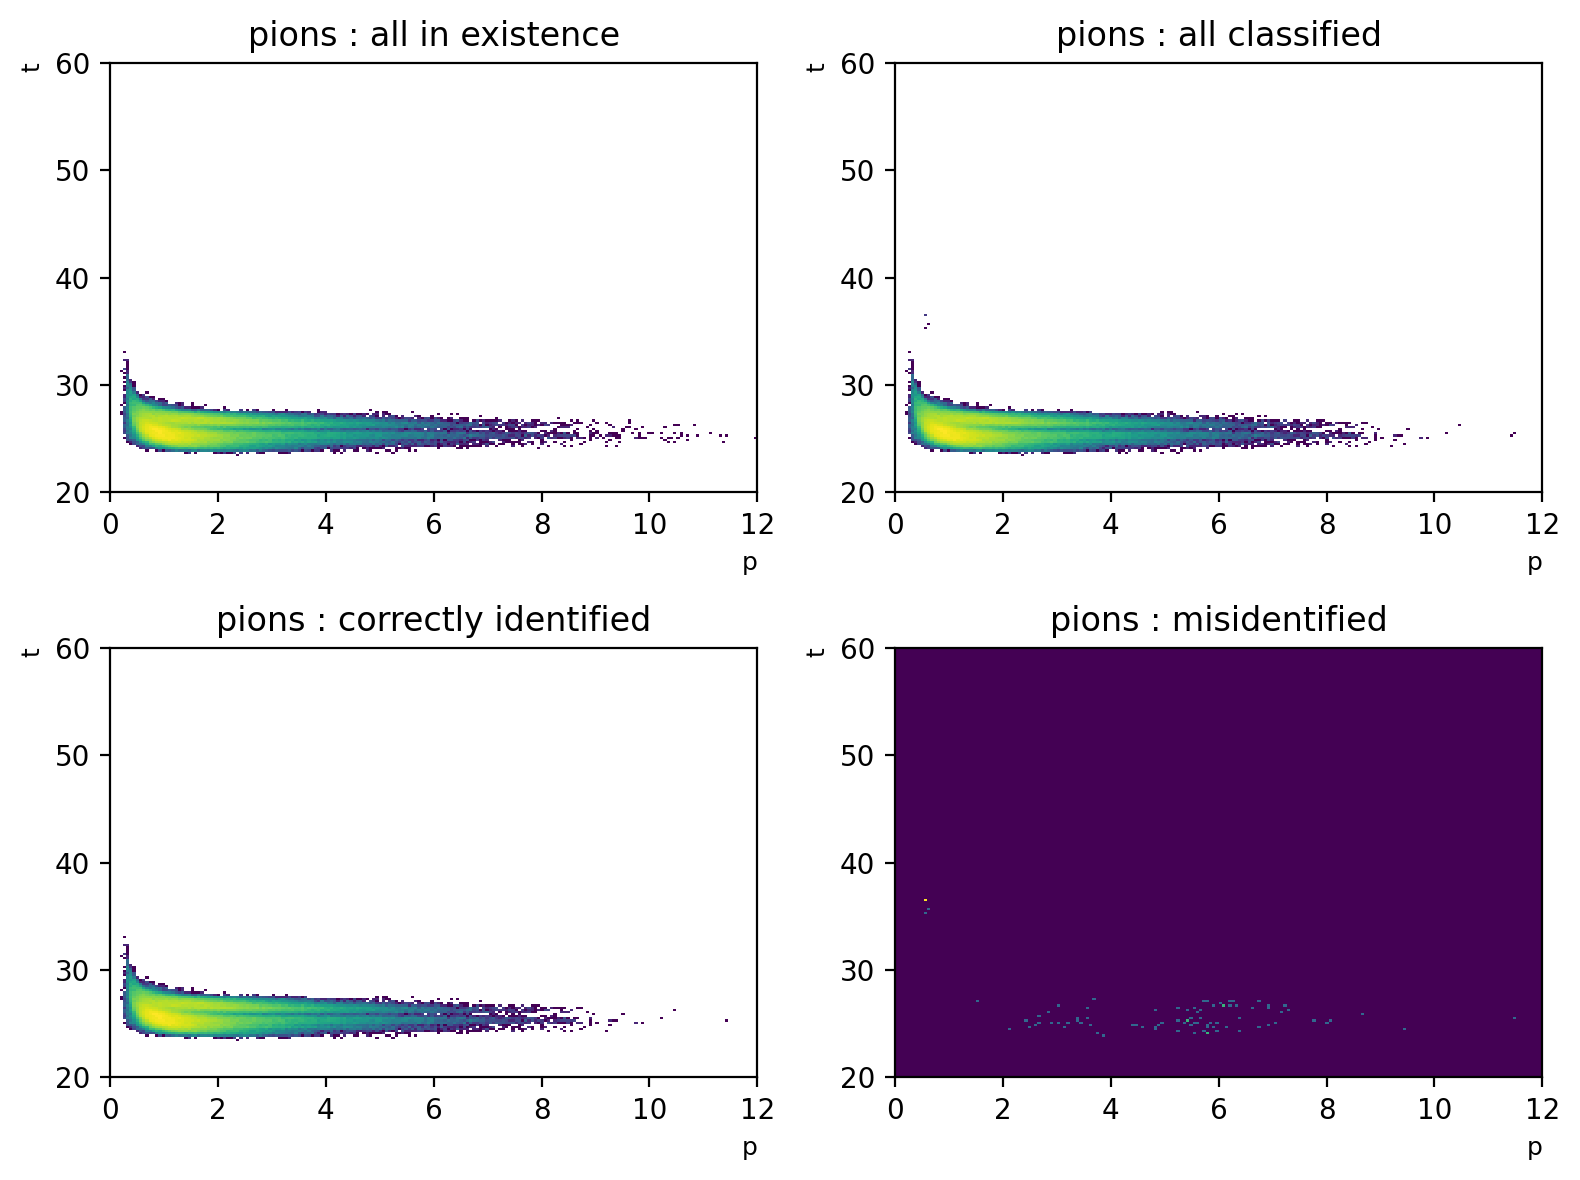

In [25]:
def draw_p_t_plot(df : pd.DataFrame, pid:int, particle_name ):
    key = f'pid_pred{pid}'

    fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=200)
    ranges = [(0,12), (20,60)]
    
    all_protons = df.loc[df['pid'] == pid]
    ax[0,0].hist2d(all_protons['p'], all_protons['t'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)
    
    all_identified = selection(df, key)
    ax[0,1].hist2d(all_identified['p'], all_identified['t'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)

    well_identified=all_identified.loc[df['pid'] == pid]
    ax[1,0].hist2d(well_identified['p'], well_identified['t'], bins=200, norm=matplotlib.colors.LogNorm(), range=ranges)

    misidentified=all_identified.loc[df['pid'] != pid]
    ax[1,1].hist2d(misidentified['p'], misidentified['t'], bins=200, range=ranges)

    x_axis_name = r"p"
    y_axis_name = r"t"

    ax[0,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[0,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   

    ax[0,0].set_title(f'{particle_name} : all in existence')
    ax[0,1].set_title(f'{particle_name} : all classified')
    ax[1,0].set_title(f'{particle_name} : correctly identified')
    ax[1,1].set_title(f'{particle_name} : misidentified')
    fig.tight_layout()
    plt.show()

draw_p_t_plot(X_test, 0,'protons')
draw_p_t_plot(X_test, 1,'kaons')
draw_p_t_plot(X_test, 2,'pions')